In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import umap
import hdbscan
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense, Input
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [2]:
import random
import string

areas_dict = {}

def str_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

def get_coded_str(_str):
    if _str not in areas_dict:
        areas_dict[_str] = str_generator()
    return areas_dict[_str]

In [3]:
df = pd.read_csv('**********')
df.columns = ['user_id', 'ui_area', 'times_viewed', 'time_spent']

In [4]:
df['ui_area'] = df['ui_area'].map(get_coded_str)

In [5]:
df.head(5)

,user_id,ui_area,times_viewed,time_spent
0,3398969716,1FTVLS,108,296636
1,3398969716,5GHOXD,24,1543
2,3398969716,260D9X,70,11454
3,3398969716,QW7JBA,22,96665
4,3398969716,0V3P0T,24,250


In [6]:
df_pivot = \
    pd.pivot_table(df, index='user_id', columns='ui_area', values='time_spent', fill_value=0)

In [7]:
def normalize_df(_df):
    return _df / _df.values.max(axis=1).reshape(-1, 1)
    # we can do the same with sum()
    # or with  _df.values / _df.values.max(axis=1)[:, np.newaxis]

df_norm = normalize_df(df_pivot) 

In [8]:
df_norm.head(10)

ui_area,08HAUX,0HES72,0LH7CV,0V3P0T,1FTVLS,1KKBWE,260D9X,2X4BAI,5GHOXD,65MUCJ,...,X4AWPT,XQ8BQ0,XVC03Z,YA5LJ9,YKVP57,YQYQB7,YTR4A1,Z4DLJG,ZIBDEW,ZOAYG7
user_id,,,,,,,,,,,,,,,,,,,,,
80000011,1.000000,0.000049,0.000008,0.000005,0.007054,0.000005,0.000012,0.000004,0.000020,0.000202,...,0.000057,0.004891,0.000048,0.000000,0.000000,0.021531,0.000000,0.000093,0.000000,0.000000
80000062,1.000000,0.013304,0.000000,0.003741,0.231899,0.000000,0.000000,0.000681,0.035161,0.000000,...,0.000000,0.000000,0.000584,0.044767,0.000000,0.000036,0.000036,0.000000,0.000055,0.000000
80000063,0.160967,1.000000,0.000183,0.000028,0.002052,0.000155,0.225905,0.000056,0.002460,0.000000,...,0.000464,0.004877,0.000000,0.115764,0.000000,0.000843,0.000239,0.000000,0.000365,0.000000
80000094,1.000000,0.000988,0.000094,0.000000,0.118475,0.000035,0.000000,0.000000,0.000637,0.000000,...,0.000000,0.120439,0.000885,0.000000,0.000000,0.067713,0.000000,0.000000,0.000024,0.000000
80000099,0.000000,0.000000,0.326814,0.000000,0.000000,0.000000,0.000000,0.000000,0.049552,1.000000,...,0.000052,0.000000,0.000000,0.000000,0.000002,0.015339,0.000433,0.000000,0.000017,0.000000
80000118,1.000000,0.000177,0.000003,0.035196,0.000031,0.000005,0.534339,0.000052,0.000011,0.000000,...,0.000005,0.064087,0.010513,0.000014,0.478546,0.185577,0.000000,0.000000,0.000003,0.000000
80000138,1.000000,0.000000,0.000058,0.000000,0.000041,0.000000,0.125022,0.000000,0.453132,0.000000,...,0.036955,0.003892,0.040534,0.001016,0.000000,0.000256,0.000000,0.000000,0.000000,0.000000
80000150,0.000627,0.000000,0.000000,0.000000,0.000122,0.000000,0.000000,0.000000,0.008931,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
80000164,0.658962,1.000000,0.207725,0.000000,0.011173,0.000000,0.019068,0.000000,0.002130,0.000067,...,0.215039,0.145624,0.000610,0.088521,0.000029,0.023413,0.000348,0.000195,0.000124,0.000543


In [9]:
def get_autoencoder(dims, act='relu'):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')

    h = x
    for i in range(n_stacks - 1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)

    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks - 1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)

    h = Dense(dims[0], name='decoder_0')(h)

    model = Model(inputs=x, outputs=h)
    model.summary()
    return model

In [10]:
def learn_manifold(x_data, umap_min_dist=0.00, umap_metric='euclidean', umap_dim=10, umap_neighbors=30):
    md = float(umap_min_dist)
    return umap.UMAP(
        random_state=0,
        metric=umap_metric,
        n_components=umap_dim,
        n_neighbors=umap_neighbors,
        min_dist=md).fit_transform(x_data)

In [11]:
X = df_norm.values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=11)

In [12]:
batch_size = 256
pretrain_epochs = 64
encoded_dimensions = 10
shape = [X.shape[-1], 500, 500, 2000, encoded_dimensions]  #-original
#shape = [X.shape[-1], 250, 250, 1000, encoded_dimensions]

print(shape)

autoencoder = get_autoencoder(shape)

[50, 500, 500, 2000, 10]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 50)]              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               25500     
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
decoder_3 (Dense)            (None, 2000)              22000     
_________________________________________________________________
decoder_2 (Dense)            

In [13]:
encoded_layer = f'encoder_{(len(shape) - 2)}'

print(f'taking the last encoder layer:{encoded_layer}')

hidden_encoder_layer = autoencoder.get_layer(name=encoded_layer).output
encoder = Model(inputs=autoencoder.input, outputs=hidden_encoder_layer)
autoencoder.compile(loss='mse', optimizer='adam')

taking the last encoder layer:encoder_3


In [14]:
#train the autoencoder
model_series = 'CLS_MODEL_' + datetime.now().strftime("%h%d%Y-%H%M")

checkpointer = ModelCheckpoint(filepath=f"{model_series}-model.h5", verbose=0, save_best_only=True)

autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=pretrain_epochs,
    verbose=1,
    validation_data=(X_test, X_test),
    callbacks=[checkpointer]
)

autoencoder = load_model(f"{model_series}-model.h5")

Epoch 1/64
104/104 [==============================] - 3s 25ms/step - loss: 0.0131 - val_loss: 0.0060
Epoch 2/64
104/104 [==============================] - 2s 24ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/64
104/104 [==============================] - 3s 24ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/64
104/104 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 5/64
104/104 [==============================] - 3s 24ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/64
104/104 [==============================] - 2s 23ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 7/64
104/104 [==============================] - 2s 23ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 8/64
104/104 [==============================] - 2s 22ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 9/64
104/104 [==============================] - 2s 23ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 10/64
104/104 [==============================] - 2s 23ms/step - loss: 0.0023 - val_lo

In [15]:
# save its weights
weights_name = 'weights/' + model_series + "-" + str(pretrain_epochs) + '-ae_weights.h5'
autoencoder.save_weights(weights_name)

In [16]:
# use the weights learned by the encoder to encode the data to a representation (embedding)
X_encoded = encoder.predict(X)

In [17]:
X_reduced = learn_manifold(X_encoded, umap_neighbors=30, umap_dim=encoded_dimensions)

In [18]:
# this is the data that we need to cluster
labels = hdbscan.HDBSCAN(
    min_samples=100,
    min_cluster_size=1000,
).fit_predict(X_reduced)

In [19]:
unique, counts = np.unique(labels, return_counts=True)
print (np.asarray((unique, counts)).T)

[[   -1   988]
 [    0  4756]
 [    1 18123]
 [    2  1622]
 [    3  1166]
 [    4  6443]]


In [20]:
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(X_reduced)

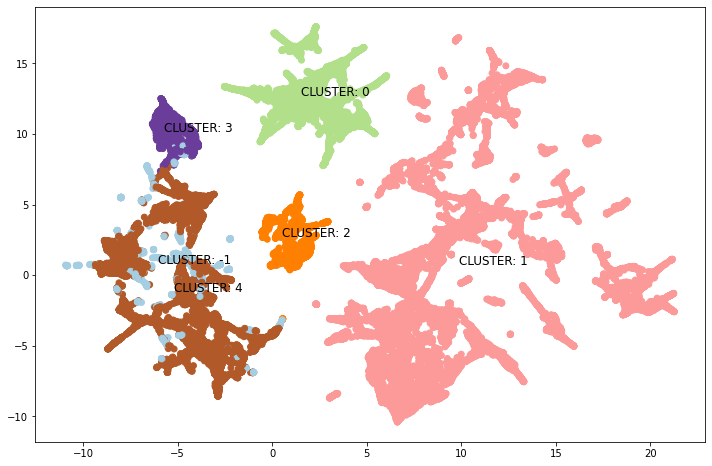

In [24]:
fig = plt.figure(figsize=(12,8))
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=labels, cmap='Paired')

viz_clusters = pd.DataFrame(embedding)
viz_clusters['cluster'] = labels

for row in viz_clusters.groupby('cluster').mean().reset_index().values:
    label = f'CLUSTER: {int(row[0])}'
    plt.annotate(label, (row[1], row[2]), textcoords="offset points", fontsize=12,  xytext=(25,0), ha='center') 